# **project-taxi-analysis**

# Build a machine learning model

## PACE: Plan 

Predict people who are particularly generous—those who will tip 20% or more

### **Task 1. Imports and data loading**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df0 = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')
nyc_preds_means = pd.read_csv('nyc_preds_means.csv')

In [4]:
df0.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [5]:
nyc_preds_means.head(5)

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


#### Join the two dataframes

In [6]:
print(df0.shape)
print(nyc_preds_means.shape)
df01=pd.concat([df0,nyc_preds_means])
print(df01.shape)

(22699, 18)
(22699, 3)
(45398, 21)


## PACE: **Analyze**

### **Task 2. Feature engineering**

In [7]:
df01.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45398 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  float64
 1   VendorID               22699 non-null  float64
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  float64
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  float64
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  float64
 9   DOLocationID           22699 non-null  float64
 10  payment_type           22699 non-null  float64
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

Customers who pay cash generally have a tip amount of $0. To meet the modeling objective, use only the customers who pay with credit card. 

In [8]:
df1=df0.copy()
df1=df1[df1['payment_type']==1]

##### **Target**

Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  

Round the result to three places beyond the decimal.


In [9]:
df1['tip_percent']=round(df1['tip_amount']/(df1['total_amount']-df1['tip_amount']),3)
df1.head(5)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tip_percent
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,0.200
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,0.238
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,0.199
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,0.300
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,0.200


Create another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

1. Begin by making the `generous` column a copy of the `tip_percent` column.
2. Reassign the column by converting it to Boolean (True/False).
3. Reassign the column by converting Boolean to binary (1/0).

In [10]:
# Create 'generous' col (target)
df1['generous']=df1['tip_percent'].copy()
df1['generous']=df1['generous']>=0.2
df1['generous']=df1['generous'].replace({True:1,False:0})
print(df1['generous'])

0        1
1        1
2        0
3        1
5        1
        ..
22692    1
22693    1
22695    1
22697    0
22698    0
Name: generous, Length: 15265, dtype: int64


#### Create day column

Convert the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns to datetime.

In [11]:
df1['tpep_pickup_datetime']=pd.to_datetime(df1['tpep_pickup_datetime'])
df1['tpep_dropoff_datetime']=pd.to_datetime(df1['tpep_dropoff_datetime'])

Create a `day` column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [12]:
# Create a 'day' col
import datetime as dt
df1['day']= df1['tpep_pickup_datetime'].dt.day_name().str.lower()
print(df1['day'])

0        saturday
1         tuesday
2          friday
3          sunday
5        saturday
           ...   
22692      sunday
22693    thursday
22695      sunday
22697    saturday
22698    thursday
Name: day, Length: 15265, dtype: object


#### Create time of day columns

Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  

To do this, first create the four columns. For now, each new column should be identical and contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [13]:
df1['am_rush']=df1['tpep_pickup_datetime'].copy()
df1['daytime']=df1['tpep_pickup_datetime'].copy()
df1['pm_rush']=df1['tpep_pickup_datetime'].copy()
df1['nighttime']=df1['tpep_pickup_datetime'].copy()

In [14]:
# Define 'am_rush()' conversion function [06:00–10:00)

def am_rush(df03):
    result = df03.copy()
    i = 0
    for temp in df03:
        
        if (temp.hour >= 6) and (temp.hour < 10):
            result.iloc[i]=1
        else:
            result.iloc[i]=0
        i=i+1
    return result

In [15]:
df1['am_rush']=am_rush(df1['am_rush'])
print(df1['am_rush'])

0        1
1        0
2        1
3        0
5        0
        ..
22692    0
22693    0
22695    0
22697    0
22698    0
Name: am_rush, Length: 15265, dtype: object


In [16]:
# Define 'daytime()' conversion function [10:00–16:00)

def daytime(df03):
    result = df03.copy()
    i = 0
    for temp in df03:
        
        if (temp.hour >= 10) and (temp.hour < 16):
            result.iloc[i]=1
        else:
            result.iloc[i]=0
        i=i+1
    return result

In [17]:
df1['daytime']=daytime(df1['daytime'])

In [18]:
# Define 'pm_rush()' conversion function [16:00–20:00)

def pm_rush(df03):
    result = df03.copy()
    i = 0
    for temp in df03:
        
        if (temp.hour >= 16) and (temp.hour < 20):
            result.iloc[i]=1
        else:
            result.iloc[i]=0
        i=i+1
    return result

In [19]:
df1['pm_rush']=pm_rush(df1['pm_rush'])

In [20]:
# Define 'nighttime()' conversion function [20:00–06:00)

def nighttime(df03):
    result = df03.copy()
    i = 0
    for temp in df03:
        
        if (temp.hour >= 20) or (temp.hour < 6):
            result.iloc[i]=1
        else:
            result.iloc[i]=0
        i=i+1
    return result

In [21]:
df1['nighttime']=nighttime(df1['nighttime'])

#### Create `month` column

Create a `month` column that contains only the abbreviated name of the month when each passenger was picked up, then convert the result to lowercase.

In [22]:
df1['month']=df1['tpep_pickup_datetime'].dt.strftime('%b')

In [23]:
print(df1['month'].head(5))

0    Mar
1    Apr
2    Dec
3    May
5    Mar
Name: month, dtype: object


#### Drop columns

Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed.

In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 22698
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             15265 non-null  int64         
 1   VendorID               15265 non-null  int64         
 2   tpep_pickup_datetime   15265 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  15265 non-null  datetime64[ns]
 4   passenger_count        15265 non-null  int64         
 5   trip_distance          15265 non-null  float64       
 6   RatecodeID             15265 non-null  int64         
 7   store_and_fwd_flag     15265 non-null  object        
 8   PULocationID           15265 non-null  int64         
 9   DOLocationID           15265 non-null  int64         
 10  payment_type           15265 non-null  int64         
 11  fare_amount            15265 non-null  float64       
 12  extra                  15265 non-null  float64       
 13  m

In [25]:
# Drop columns
df04=df1.drop(['VendorID','tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count','payment_type','trip_distance','tip_amount','tip_percent','total_amount','tolls_amount','fare_amount','extra','mta_tax','store_and_fwd_flag','improvement_surcharge'],axis=1)

#### Variable encoding

In [30]:
# 1. Define list of cols to convert to string
cols_to_str = {'RatecodeID', 'PULocationID', 'DOLocationID'}

# 2. Convert each column to string
for col in cols_to_str:
    df04[col]=df04[col].astype('str')

In [31]:
print(df04.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 22698
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    15265 non-null  int64 
 1   RatecodeID    15265 non-null  object
 2   PULocationID  15265 non-null  object
 3   DOLocationID  15265 non-null  object
 4   generous      15265 non-null  int64 
 5   day           15265 non-null  object
 6   am_rush       15265 non-null  object
 7   daytime       15265 non-null  object
 8   pm_rush       15265 non-null  object
 9   nighttime     15265 non-null  object
 10  month         15265 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.4+ MB
None


In [32]:
# Convert categoricals to binary
df2 = pd.get_dummies(df04)

##### Evaluation metric

In [33]:
# Get class balance of 'generous' col
df2['generous'].value_counts()

1    8035
0    7230
Name: generous, dtype: int64

## PACE: **Construct**

### **Task 3. Modeling**

##### **Split the data**

In [34]:
# Isolate target variable (y)
y=df2['generous']

# Isolate the features (X)
X=df2.drop(['generous'], axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, stratify=y, 
                                                    random_state=42)

##### **Random forest**

In [36]:
import pickle 

path = '/assets/'

def write_pickle(path, model_object, save_name:str):
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)
        
def read_pickle(path, saved_model_name:str):
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [37]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# 2. Create a dictionary of hyperparameters to tune 
cv_params = {'max_depth': [2,3,4, None], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125]
             }  

# 3. Define a set of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

In [39]:
rf_cv = read_pickle('/home/jovyan/work/',"rf_cv")

In [36]:
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

Examine the best average score across all the validation folds. 

In [40]:
# Examine best score
rf_cv.best_score_

0.6897032786235879

Examine the best combination of hyperparameters.

In [41]:
rf_cv.best_params_

{'max_depth': 4,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 75}

In [42]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [43]:
rf_cv_results = make_results('Random Forest CV', rf_cv,'f1')
rf_cv_results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.526415,0.999844,0.689703,0.526449


Use your model to predict on the test data. Assign the results to a variable called `rf_preds`.

In [44]:
# Get scores on test data
rf_preds = rf_cv.predict(X_test)

Use the below `get_test_scores()` function you will use to output the scores of the model on the test data.

In [45]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

###### RF test results

In [46]:
 # Get scores on test data
get_test_scores('Random Forest CV', rf_preds, y_test)

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.526368,1.0,0.6897,0.526368


##### **XGBoost**

In [47]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0) 

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4], 
             'min_child_weight': [1,3],
             'learning_rate': [0.1],
             'n_estimators': [75]
             }    

# 3. Define a set of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

In [48]:
xgb_cv = read_pickle('/home/jovyan/work/', "xgb_cv")

In [39]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 49min 11s, sys: 8.13 s, total: 49min 19s
Wall time: 24min 40s


GridSearchCV(cv=4, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     predictor=None, random_state=0,
                   

Get the best score from this model.

In [49]:
# Examine best score
xgb_cv.best_score_

0.6424775401091627

And the best parameters.

In [50]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 75}

##### XGB CV Results

In [51]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGBoost CV', xgb_cv, 'f1')

In [52]:
# Get scores on test data
xgb_preds = xgb_cv.predict(X_test)

###### XGB test results

In [53]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGBoost CV', xgb_preds, y_test)

Plot a confusion matrix of the model's predictions on the test data.

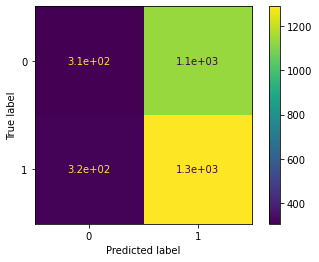

In [54]:
# Generate array of values for confusion matrix
model = xgb_cv
cm = confusion_matrix(y_test, xgb_preds, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Plot confusion matrix
disp.plot()
plt.show()

##### Feature importance

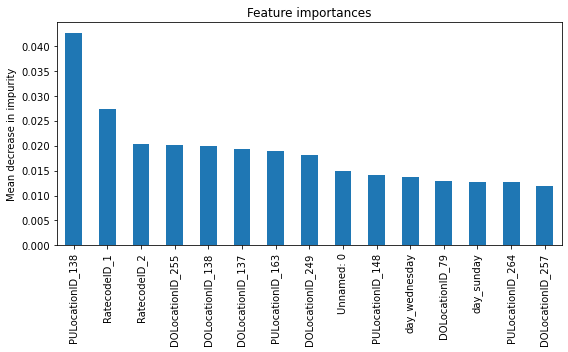

In [55]:
rf1=rf_cv
importances = rf1.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();

## PACE: **Execute**

### **Task 4. Conclusion**

In this step, use the results of the models above to formulate a conclusion. Consider the following questions:

1. **Would you recommend using this model? Why or why not?**  

2. **What was your model doing? Can you explain how it was making predictions?**   

3. **Are there new features that you can engineer that might improve model performance?**   

4. **What features would you want to have that would likely improve the performance of your model?**   

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion. Even if you cannot use the model to make strong predictions, was the work done in vain? Consider any insights that you could report back to stakeholders.